Dana Rozenblum & Efrat Magidov

# Decision Trees Exercise
In this exercise you will show that ID3 is sub-optimal. Implement a simple version of Random Forest, and will then apply a Decision Tree classsifier and random forest on the MNIST hand written digits dataset that we already saw.


## Suboptimality of ID3
Consider the following training set, where $\mathcal{X} = \{0, 1\}^3$ and $\mathcal{Y} =\{0, 1\}$:

$$
\begin{aligned}
((1, 1, 1), 1)\\
((1, 0, 0), 1)\\
((1, 1, 0), 0)\\
((0, 0, 1), 0)
\end{aligned}
$$

Suppose we wish to use this training set in order to build a decision tree of depth 2 (i.e. for each
input we are allowed to ask two questions of the form "$x_i = 0$?" before deciding on the label).

1. Suppose we run the ID3 algorithm up to depth 2 (namely, we pick the root node and its
children according to the algorithm, but instead of keeping on with the recursion, we stop
and pick leaves according to the majority label in each subtree, once we reach depth 2). 
Assume that the subroutine used to measure the quality of each feature is based on the information gain, and that if two features get the same score, one of them is picked arbitrarily. 
Show that the training error of the resulting decision tree is at least 1/4.
2. Find a decision tree of depth 2, which attains zero training error.


#### Answer

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = np.array([[1,1,1,1], [1,0,0,1], [1,1,0,0], [0,0,1,0]])

In [3]:
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy


In [4]:
def InfoGain(data,attribute_col):
  
    #Calculate the entropy of the total dataset
    total_entropy = entropy(data[:,-1])
    
    #Calculate the values and the corresponding counts for the attribute 
    vals,counts= np.unique(data[:,attribute_col],return_counts=True)   
    
    #Calculate the weighted entropy of the attribute
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data[data[:,attribute_col]==vals[i],-1]) for i in range(len(vals))])    
    
    #Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    
    return Information_Gain


In [5]:
def ID3(data, features=None, tree=None, max_depth=2, criterion='max_ig'): 

    if features is None:
        features = list(range(data.shape[1]-1))           
        
    #Select the feature which best splits the dataset based on information gain
    ig_values = [InfoGain(data,feature) for feature in features]
    #Return the information gain values for the features in the dataset
    if criterion=='max_ig':
        best_feature_index = np.argmax(ig_values)
    elif criterion=='min_ig':
        best_feature_index = np.argmin(ig_values)
    best_feature = features[best_feature_index]
    
    #Remove used attribute
    features = [i for i in features if i != best_feature]

    #Intitialize tree
    if tree is None:                    
        tree={}
        tree[best_feature] = {}

    for value in np.unique(data[:,best_feature]):

        subtable = data[data[:,best_feature] == value]
        clValue,counts = np.unique(subtable[:, -1],return_counts=True)                        
        
        if len(counts) == 1:# Checking purity of subset
            tree[best_feature][value] = clValue[0]
        elif len(features) < max_depth & data.shape[0] > 0:
            tree[best_feature][value] = clValue[counts.argmax()]
        else:        
            tree[best_feature][value] = ID3(subtable, features) #Calling the function recursively 

    return tree


In [6]:
def predict(inst,tree):    
    #Recursively go through the tree dictionary to predict per instance

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction


In [7]:
def prediction_error(data,tree):
    error = 0
    n_samples = len(data)
    for row in range(n_samples):
        if predict(data[row,:],tree) != data[row,-1]:
            error += 1
    return error / n_samples


In [8]:
tree = ID3(data)

In [9]:
tree

{0: {0: 0, 1: {1: {0: 1, 1: 0}}}}

In [10]:
prediction_error(data, tree)

0.25

We see that only the first feature (first column) gains information to the model preiction. This means ID3 will start from it by deafult. This is a limitation of ID3 since this preferation bias, where some hypothesis is preferred, may result in suboptimal performence (training bias).

To get a decision tree of depth 2, which attains zero training error, we can change the splitting criterion to the attribute with the minimum information gain.

In [11]:
# rerun id3 only on data[:,1:]
tree2 = ID3(data, criterion='min_ig')
tree2

{1: {0: {0: {0: 0, 1: 1}}, 1: {2: {0: 0, 1: 1}}}}

In [12]:
prediction_error(data, tree2)

0.0

## Implementing Random Forest From Scratch
In this exercise you will need to implement a simple version of Random Forest Regressor from scratch. Your decision tree will handle **continuous input and output** (this should actually work also for binary input attributes). 

* Compelete the skeleton class below (hint: you should also create a `DecisionTree` class that the `TreeEnsemble` will use)
  - `X` is a matrix of data values (rows are samples, columns are attributes)
  - `y` is a vector of corresponding target values
  - `n_trees` is the number of trees to create
  - `sample_sz` is the size of the sample set to use of each of the trees in the forest (chose the samples randomly, with or without repetition)
  - `min_leaf` is the minimal number of samples in each leaf node of each tree in the forest
  
* For splitting criterion, use either **"Train Squared Error Minimization (Reduction in Variance)"** or **"Train Absolute Error Minimization"** (choose one). Whatever you choose, make sure you implement the splitting point decision efficiently (in $O(n)$ time).

* The `predict` function will use mean of the target values in the leaf node matching each row of the given `X`. The result is a vector of predictions matching the number of rows in `X`.

* The `oob_mse` function will compute the mean squared error over all **out of bag (oob)** samples. That is, for each sample calculate the squared error using  predictions from the trees that do not contain x in their respective bootstrap sample, then average this score for all samples. See:  [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

* To check your random forest implementation, use the boston dataset (`from sklearn.datasets import load_boston`)

  - Use the following to estimate what are the best hyper parameters to use for your model
```
for n in [1,5,10,20,50,100]:
  for sz in [50,100,300,500]:
    for min_leaf in [1,5]:
      forest = TreeEnsemble(X, y, n, sz, min_leaf)
      mse = forest.oob_mse()
      print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
```
  
  - Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the training set . Use something like:
  ```
  y_hat = forest.predict(X)  # forest is the chosen model
  plt.scatter(y_hat, y)
  ```
  



In [13]:
import numpy as np
np.random.seed(2)

# calculates variance for find best split
def var_agg(cnt, s1, s2): return abs((s2 / cnt) - (s1 / cnt) ** 2)

# regression decision tree. includes random selection of features at each level
class DecisionTree():
    
    # create and fit. Each tree is created with different features
    def __init__(self, x, y, n_features, f_idxs, idxs, min_leaf, leaf_val, leaf_idx,leaf_split):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.n_features = n_features
        self.n = idxs.size
        self.val = leaf_val
        self.var_idx = leaf_idx
        self.split = leaf_split
        self.score = float('inf')
        
        if self.n >= min_leaf:
            self.val = np.mean(y[idxs])
            self.find_varsplit()
            
    # sets the split feature with the split point and creates the next level trees
    def find_varsplit (self):
        
        for i in self.f_idxs: self.find_better_split(i)
            
        if self.is_leaf: return
        
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], min_leaf = self.min_leaf,
                                leaf_val = self.val, leaf_idx=self.var_idx,leaf_split=self.split)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], min_leaf = self.min_leaf,
                                leaf_val = self.val,leaf_idx=self.var_idx,leaf_split=self.split)
    
    # for a given feature - finds the best split point based on the greedy approach. for efficiency - the x data is sorted 
    # (O(nlogn)) and then variance is calculated on two sides of data while increasing one side and decreasing the other for
    # performing it with O(n). each time we choose the split where the weighted sum of left and right sides is minimal
    def find_better_split(self, var_idx):
        x = self.x[self.idxs, var_idx]
        y = self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y = y[sort_idx]
        sort_x = x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0,0., 0.
        
        for i in range (0, self.n-self.min_leaf-1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi ** 2; rhs_sum2 -= yi ** 2
            
            if xi == sort_x[i + 1] or i < self.min_leaf:
                continue
            
            lhs_var = var_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_var = var_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = rhs_cnt*rhs_var + lhs_cnt*lhs_var
            
            if curr_score < self.score: 
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
                
    @property
    def split_col(self): return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    # predict function
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    # run each row through the tree
    def predict_row(self, xi):
        
        if self.is_leaf:
            return self.val
        
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        
        return t.predict_row(xi)

In [14]:
class TreeEnsemble():
    
    # creates the forest. the number of features for each tree will be sqrt of total number of features
    def __init__(self, X, y, n_trees, sample_sz, min_leaf):
        self.n_features = int(np.sqrt(X.shape[1]))
        self.X, self.y, self.sample_sz, self.min_leaf = X, y, sample_sz, min_leaf
        self.oob = {}
        self.trees = [self.create_tree(i) for i in range(n_trees)]
        
    # randomly select features and data sample and creates a tree.
    # also, for out of bag mse - creates dictionary which holds for each sample all the trees that this sample wasn't used for training
    def create_tree(self,i):
        f_idxs = np.random.permutation(self.X.shape[1])[:self.n_features]
        idxs = np.random.choice(len(self.y), self.sample_sz)
        val_indxs = np.setdiff1d(np.arange(len(self.y)),idxs)
        tree_num = i
        
        for sample in val_indxs:
            
            if sample in self.oob:
                self.oob[sample].append(tree_num)
            else:
                self.oob[sample] = []
                self.oob[sample].append(tree_num)
   
        return DecisionTree(self.X[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs = np.array(range(self.sample_sz)), min_leaf = self.min_leaf, leaf_val = 0,leaf_idx=0,leaf_split=0)
    
    # prediction is the average prediction of all the trees
    def predict(self, X):
        return np.mean([t.predict(X) for t in self.trees], axis = 0)
  
    # For each sample row we kept a list of all the trees of which it wasn't used for train. Now for each sample we predict
    # with all the trees from its list and the predicion is the mean of all trees prediction. For each sample we calculate the
    # mse error by comparing the prediction and the true sample value. the forest OOB MSE is the mean of all samples mse.
    def oob_mse(self):
        predicts = {}
        errors = []
        
        for key, value in self.oob.items():
            all_preds = []
            for tree in value:
                all_preds.append(self.trees[tree].predict_row(self.X[key]))
            y_total = sum(all_preds) / len(all_preds)
            predicts[key] = y_total
        
        for key_p, value_p in predicts.items():
            Y_true = self.y[key_p]
            Y_pred = value_p
            MSE = np.square(Y_true - Y_pred)
            errors.append(MSE)
            
        return np.mean(errors)
        

In [ ]:
# estimate what are the best hyper parameters to use for the model
np.random.seed(2)
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
min_mse = 60.0

for n in [1,5,10,20,50,100]:
    for sz in [50,100,300,500]:
        for min_leaf in [1,5]:
            forest = TreeEnsemble(X, y, n, sz, min_leaf)
            mse = forest.oob_mse()
            print("n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(n, sz, min_leaf, mse))
            if (mse < min_mse):
                best_n = n
                best_sz = sz
                best_leaf = min_leaf
                min_mse = mse
print("best oob: n_trees:{0}, sz:{1}, min_leaf:{2} --- oob mse: {3}".format(best_n, best_sz, best_leaf, min_mse))


n_trees:1, sz:50, min_leaf:1 --- oob mse: 52.40023158278629
n_trees:1, sz:50, min_leaf:5 --- oob mse: 81.21182101921701
n_trees:1, sz:100, min_leaf:1 --- oob mse: 75.94059254775357
n_trees:1, sz:100, min_leaf:5 --- oob mse: 35.75478197719184
n_trees:1, sz:300, min_leaf:1 --- oob mse: 26.33829695998446
n_trees:1, sz:300, min_leaf:5 --- oob mse: 33.42039783063424
n_trees:1, sz:500, min_leaf:1 --- oob mse: 32.714226853771805
n_trees:1, sz:500, min_leaf:5 --- oob mse: 36.36776826234264
n_trees:5, sz:50, min_leaf:1 --- oob mse: 36.81342326144903
n_trees:5, sz:50, min_leaf:5 --- oob mse: 30.869893840872024
n_trees:5, sz:100, min_leaf:1 --- oob mse: 24.925703631060802
n_trees:5, sz:100, min_leaf:5 --- oob mse: 26.544456723452743
n_trees:5, sz:300, min_leaf:1 --- oob mse: 21.74604187681966
n_trees:5, sz:300, min_leaf:5 --- oob mse: 23.245486694889884
n_trees:5, sz:500, min_leaf:1 --- oob mse: 26.188746263455272
n_trees:5, sz:500, min_leaf:5 --- oob mse: 22.414209719681285
n_trees:10, sz:50, mi

MSE:  3.0308754275820347


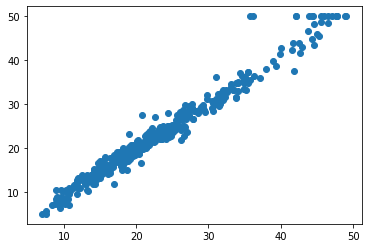

In [ ]:
# Using your chosen hyperparameters as a final model, plot the predictions vs. true values of all the samples in the
# training set
np.random.seed(2)
import matplotlib.pyplot as plt

forest_chosen = TreeEnsemble(X, y, best_n, best_sz, best_leaf)
y_hat = forest_chosen.predict(X)
plt.scatter(y_hat, y)

print("MSE: ", np.square(np.subtract(y,y_hat)).mean())

## Using Decision Tree and Random Forest for Digits Classification
Remeber the MNIST dataset used - you will now test the power of decision trees on this problem.
This time you are given a free hand in choosing the test and train set sizes, model parameters (such as gain function and constraints over the trees) and features (whether to use binary pixel values or the original continous gray value).
- Choose which model parameters you wish to optimize, explain how would you do that, and find a model which you believe would have the minimal generalization error --- do this for both a single decision tree model, and a random forest.
  - You can use `sklearn.tree.DecisionTreeClassifier` and `sklearn.ensemble.RandomForestClassifier`
- Once you are satisfied with the model parameters, plot for each of the models (a single decision tree and random forest) the importance of each of the pixels to the final decision.
- Last, estimate the class assignment probabilities for all the correctly classified and misclassified examples in your test data.
- Discuss your results.

### Downloading and preparing the data:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import check_random_state


In [ ]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Random Forest Classifier:

In [ ]:
# random forest classifier - deafult settings
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y_train)
pred_y_forest = random_forest_classifier.predict(X_test)

In [ ]:
print("Accuracy for random forest with deafult settings: {}%".format(accuracy_score(y_test, pred_y_forest)*100))
print("Confusion Matrix:")
print("{}".format(confusion_matrix(y_test, pred_y_forest)))

Accuracy for random forest with deafult settings: 96.88%
Confusion Matrix:
[[ 970    0    0    0    0    3    2    1    3    1]
 [   0 1123    1    5    0    2    2    0    1    1]
 [   5    0 1000    6    4    0    4    8    5    0]
 [   0    0   12  968    0   11    0    9    8    2]
 [   1    0    1    0  957    0    5    0    2   16]
 [   3    1    0   11    3  860    7    2    3    2]
 [   9    3    0    0    2    2  938    0    4    0]
 [   1    3   19    0    1    0    0  989    2   13]
 [   3    0    6    9    4    5    6    4  928    9]
 [   5    6    2    9   16    4    1    4    7  955]]


In [ ]:
"""
Using grid search cross validation for optimization of the hyperparameters:
1) number of trees (n_estimators)
2) max number of levels in each desicion tree (max_depth)
3) min number of data points placed in a node before the node is split (min_samples_split)
4) max number of features considered for splitting a node (max_features)
"""


from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 4],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(random_forest_classifier, param_grid = param_grid, cv = 5, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator_forest = grid.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 502.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 629.0min finished


In [ ]:
best_estimator_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# creating a new model with the parameters found on the gridsearch CV
random_forest_classifier_optimized = RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=2, n_estimators=200)
random_forest_classifier_optimized.fit(X_train, y_train)
pred_y_forest = random_forest_classifier_optimized.predict(X_test)

In [ ]:
print("Accuracy after hyperparameter tuning: {}%".format(accuracy_score(y_test, pred_y_forest)*100))
print("Confusion Matrix:")
print("{}".format(confusion_matrix(y_test, pred_y_forest)))

Accuracy after hyperparameter tuning: 97.05%
Confusion Matrix:
[[1331    0    1    0    0    4    3    1    7    0]
 [   0 1565    6    3    4    2    2    3    2    1]
 [   6    2 1394    8    5    1    3    8    7    2]
 [   2    0   18 1382    1   12    0   10    8    3]
 [   3    2    2    0 1275    0    4    3    2   16]
 [   4    5    1   12    2 1248    8    1    8    5]
 [   8    3    1    0    2    6 1340    0    5    0]
 [   0    3   18    0    4    0    0 1452    2   10]
 [   3    7    9   10    5   10    8    1 1294   17]
 [   4    1    2   16   11    4    1   12   17 1306]]


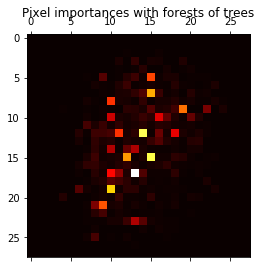

In [ ]:
importances_forest = random_forest_classifier_optimized.feature_importances_
importances_forest = importances.reshape(28, 28)

# Plot pixel importances
plt.matshow(importances_forest, cmap=plt.cm.hot)
plt.title("Pixel importances with forests of trees")
plt.show()

In [ ]:
print(classification_report(y_test, pred_y_forest))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1402
           1       0.99      0.99      0.99      1556
           2       0.96      0.98      0.97      1368
           3       0.96      0.95      0.96      1339
           4       0.98      0.97      0.97      1395
           5       0.98      0.97      0.97      1261
           6       0.98      0.98      0.98      1418
           7       0.97      0.97      0.97      1463
           8       0.96      0.97      0.97      1362
           9       0.96      0.95      0.95      1436

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



In [ ]:
class_precision_forest = precision_recall_fscore_support(y_test, pred_y_forest)[0]

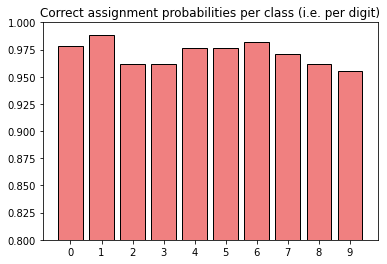

In [ ]:
plt.bar(range(10),class_precision_forest,color='lightcoral', edgecolor='k')
plt.xticks(range(10))
plt.ylim((0.8,1))
plt.title("Correct assignment probabilities per class (i.e. per digit)")
plt.show()

### Desicion Tree Classifier:

In [ ]:
# desicion tree classifier - deafult settings
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)
pred_y_tree = tree_classifier.predict(X_test)

In [ ]:
print("Accuracy for desicion tree with deafult settings: {}%".format(accuracy_score(y_test, pred_y_tree)*100))
print("Confusion Matrix:")
print("{}".format(confusion_matrix(y_test, pred_y_tree)))

Accuracy for desicion tree with deafult settings: 87.60714285714286%
Confusion Matrix:
[[1271    2   10   16    3   24   24    1   11    9]
 [   2 1536   14   11    5    9    3   11   15    7]
 [  21    5 1227   33   21   18   17   32   47   16]
 [  12    9   35 1205   12   46   10   23   25   30]
 [   4   10   15   13 1154   14   12   16   27   80]
 [  16    4    9   60    9 1042   22    8   42   23]
 [  19   10   24    9   20   34 1218    1   23    8]
 [   7    8   21   21   18    9    4 1330   12   37]
 [  13   20   41   38   26   41   32   13 1068   37]
 [  10    7   12   29   54   24    5   35   40 1214]]


For choosing which hyperparameters we should optimize, we'll rely on the paper "An empirical study on hyperparameter tuning of decision trees [5] which indicates that min_samples_split and min_samples_leaf are the most responsible for the performance of the final trees from their relative importance analysis

In [ ]:
"""
Using grid search cross validation for optimization of the hyperparameters:
1) max depth of the tree
2) min number of samples required to be at a leaf node (min_samples_leaf)
3) min number of data points placed in a node before the node is split (min_samples_split)
"""

param_grid = {
    'max_depth': list(range(4,20)),
    'min_samples_leaf': list(range(2,10)), 
    'min_samples_split': list(range(2,10))
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid, cv = 5, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator = grid.best_estimator_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 50.7min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 67.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 89.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 114.4min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 150.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 195.4min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 247.5min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 304.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      

In [ ]:
best_estimator

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=19, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_classifier_optimized = DecisionTreeClassifier(max_depth=19, min_samples_leaf=4, min_samples_split=6)
tree_classifier_optimized.fit(X_train, y_train)
pred_y_tree = tree_classifier_optimized.predict(X_test)

In [ ]:
print("Accuracy after hyperparameter tuning: {}%".format(accuracy_score(y_test, pred_y_tree)*100))
print("Confusion Matrix:")
print("{}".format(confusion_matrix(y_test, pred_y_tree)))

Accuracy after hyperparameter tuning: 87.71428571428571%
Confusion Matrix:
[[1261    1   16    7    4   17   11    5   18    7]
 [   3 1525   11   17    1   11    3    8    6    3]
 [  32   17 1209   32   26   13   18   30   47   12]
 [  15   14   39 1213   13   65    7   21   32   17]
 [   6    3   13   10 1151   15   10   21   16   62]
 [  18   16   16   53   19 1093   20    4   36   19]
 [  24   10   19    5   21   34 1229    0   19    4]
 [   5   14   25   21   12    9    3 1353    8   39]
 [  18   21   43   55   31   41   24   15 1081   35]
 [   6   10   27   15   50   33    8   33   27 1165]]


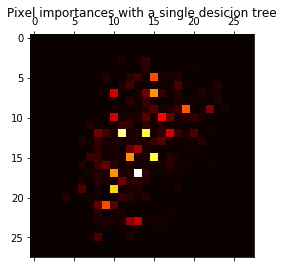

In [ ]:
# importance of each pixel
importances = tree_classifier_optimized.feature_importances_
importances = importances.reshape(28, 28)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances with a single desicion tree")
plt.show()

In [ ]:
print(classification_report(y_test, pred_y_tree))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1402
           1       0.94      0.96      0.95      1556
           2       0.84      0.86      0.85      1368
           3       0.85      0.83      0.84      1339
           4       0.86      0.86      0.86      1395
           5       0.83      0.84      0.83      1261
           6       0.90      0.88      0.89      1418
           7       0.92      0.90      0.91      1463
           8       0.83      0.81      0.82      1362
           9       0.85      0.84      0.85      1436

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



In [ ]:
class_precision_tree = precision_recall_fscore_support(y_test, pred_y_tree)[0]

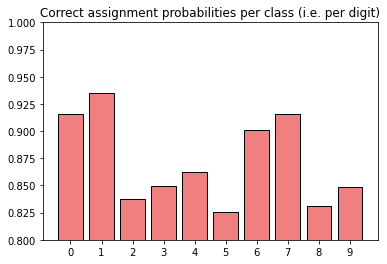

In [ ]:
plt.bar(range(10),class_precision_tree,color='lightcoral', edgecolor='k')
plt.xticks(range(10))
plt.ylim((0.8,1))
plt.title("Correct assignment probabilities per class (i.e. per digit)")
plt.show()

### Comparing the two models:

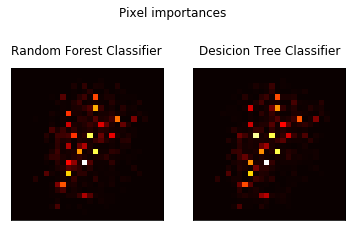

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Pixel importances')

ax1.matshow(importances_forest, cmap=plt.cm.hot)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Random Forest Classifier')

ax2.matshow(importances, cmap=plt.cm.hot)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('Desicion Tree Classifier')

plt.show()


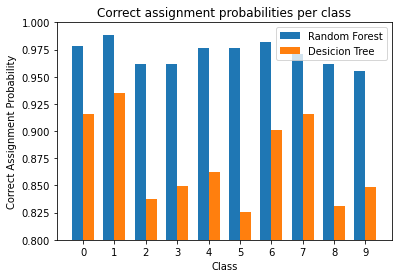

In [ ]:
fig, ax = plt.subplots()
labels = np.arange(10)
width = 0.35  # the width of the bars

rects1 = ax.bar(labels - width/2, class_precision_forest, width, label='Random Forest')
rects2 = ax.bar(labels + width/2, class_precision_tree, width, label='Desicion Tree')

ax.set_ylabel('Correct Assignment Probability')
ax.set_xlabel('Class')
ax.set_title('Correct assignment probabilities per class')
ax.set_xticks(labels)
ax.set_ylim([0.8, 1])
ax.legend()

plt.show()

### Dicsussion:

In this task we aimed to choose parameters for both Random Forest (RFC) and Desicion Tree (DTC) classifiers with the aim of optimizing the models' generalization performance.

In order to fine tune the hyperparameters and find the ones which generalize better, “grid-search”  using cross-validation (fivefold cross-validation) was used. First, we defined the parameters we want to optimize and the values we want to assign to them for the grid examination. Then the best parameters were used to train the whole training set and generate the final model. Finally, the relative pixel contribution for classification, and the prediction accuracy per class were evaluated.


#### Conclusions:
- As expected, the RFC yeilds much better results compared to the single DTC (~97% accuracy compared to ~87% accuracy).  The better performance is also visible at the class level as seen at the class accuracy bar plot.
- Running the gridsearch on the continous range of paramters' values (as done for DTC) is, obviously, much more costly computationaly, and the best practice is choosing a spaced subset of the parameter values' space (as done in RFC). Optimally, one should combine the two searching methods: start with a sparsed range and gradually decrease the resolution until finding the optimal parameters values.
- The parameters optimization resulting from the grid search was not manifested in improved model accuracy. This teaches us that better generalization performance does not neccesarily means better prediction of the current test data.

## References
- https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/